In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
data = pd.read_csv('ethereum_daily_data_2018_2024.csv')
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data.head()

,Open,High,Low,Close,Volume
time,,,,,
2018-01-01,741.69,766.49,718.90,757.22,910875.63
2018-01-02,756.17,882.61,756.17,861.97,1123318.86
2018-01-03,861.97,951.70,847.90,941.10,871172.13
2018-01-04,941.00,997.44,901.03,944.83,822844.78
2018-01-05,944.50,1165.81,926.75,963.88,1682729.53


In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(data.Close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.397600
p-value: 0.583426


In [ ]:
def best_d(data):
  flag = True
  d = 0
  while(flag == True):
    s1 = data.Close.diff().dropna()
    result = adfuller(s1)
    if(result[1] < 0.05):
      flag = False
    d = d + 1
  return d, s1.dropna()

In [ ]:
optimal_d, s1 = best_d(data)
print(f"Valore ottimale di diffenziazione: {optimal_d}")

Valore ottimale di diffenziazione: 1


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (14, 7), 'figure.dpi': 120})

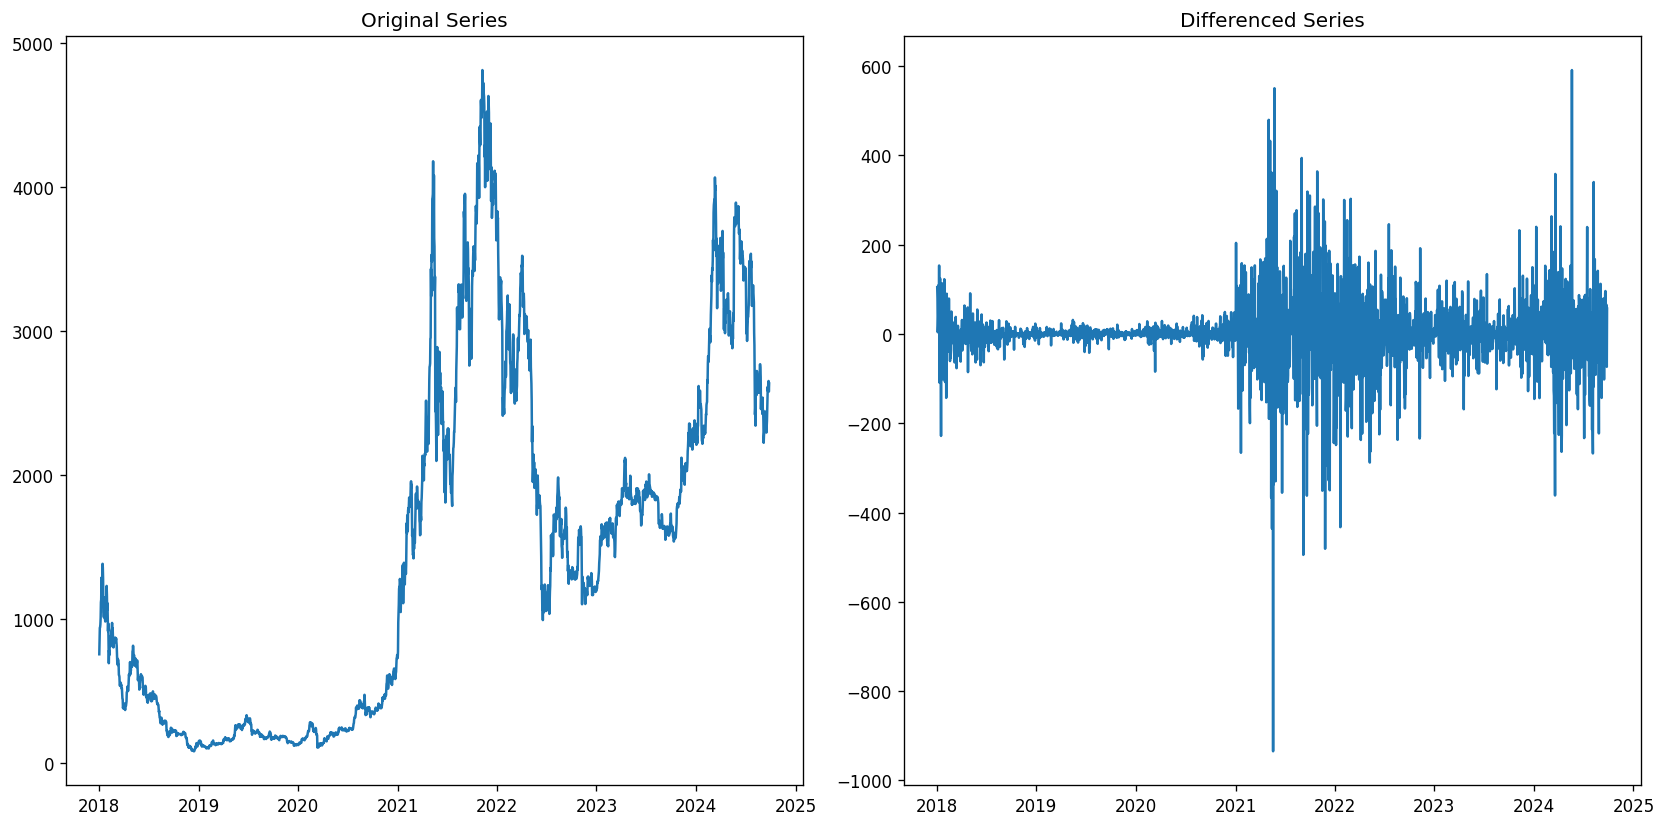

In [ ]:
fig1, axes1 = plt.subplots(1, 2, figsize=(14, 7), sharex=False)

axes1[0].plot(data.Close)
axes1[0].set_title('Original Series')

axes1[1].plot(s1)
axes1[1].set_title('Differenced Series')

fig1.tight_layout()
plt.show()

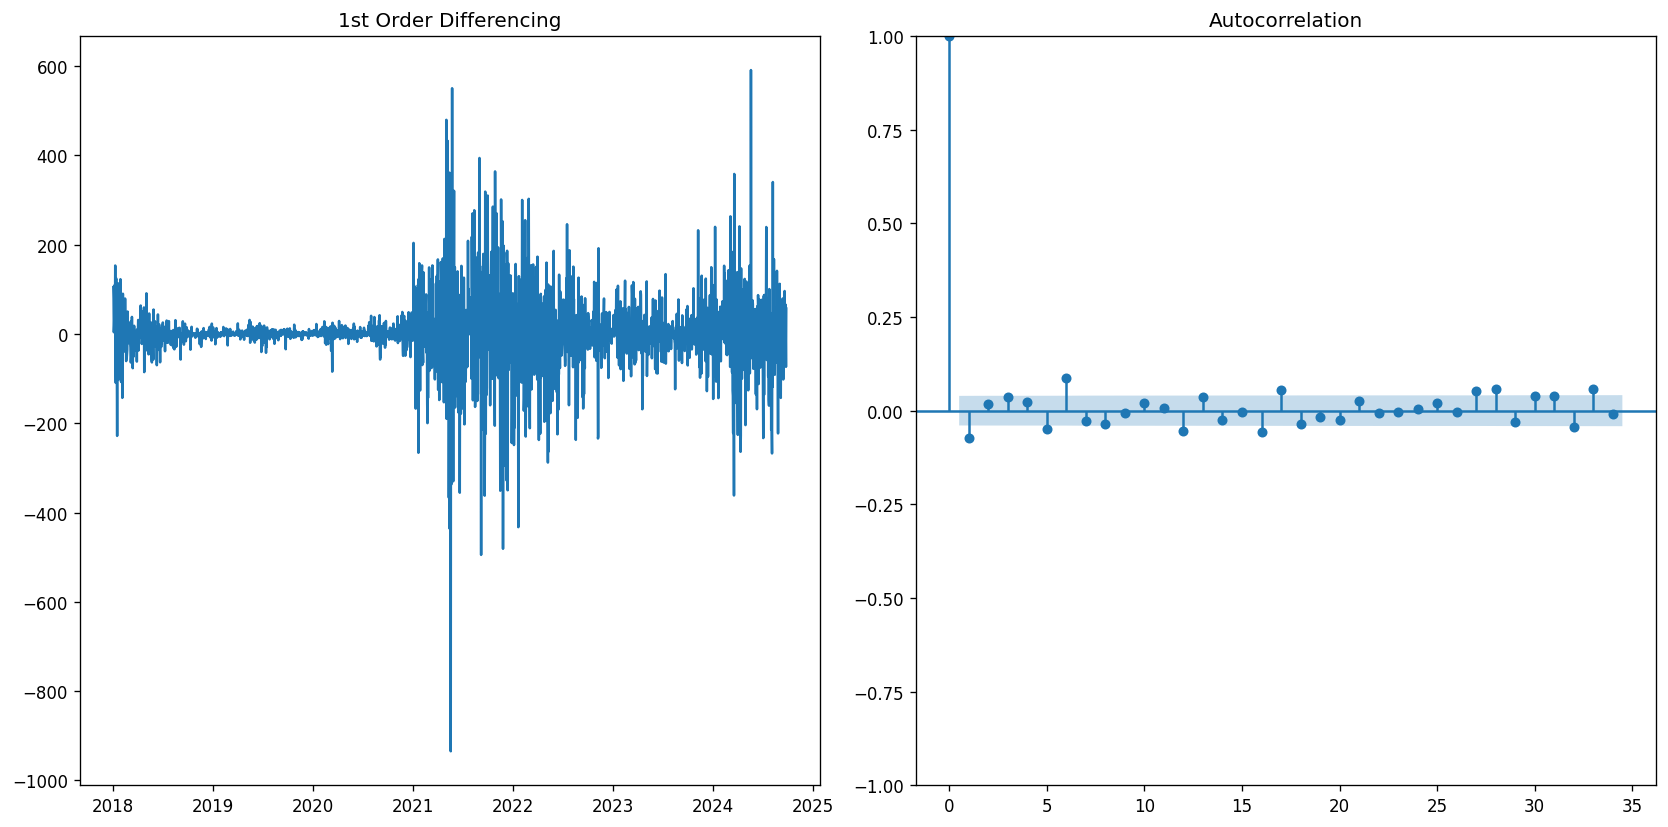

In [ ]:
fig2, axes2 = plt.subplots(1, 2, sharex=False)
axes2[0].plot(s1)
axes2[0].set_title('1st Order Differencing')
plot_acf(s1, ax=axes2[1])
fig2.tight_layout()
fig2.show()

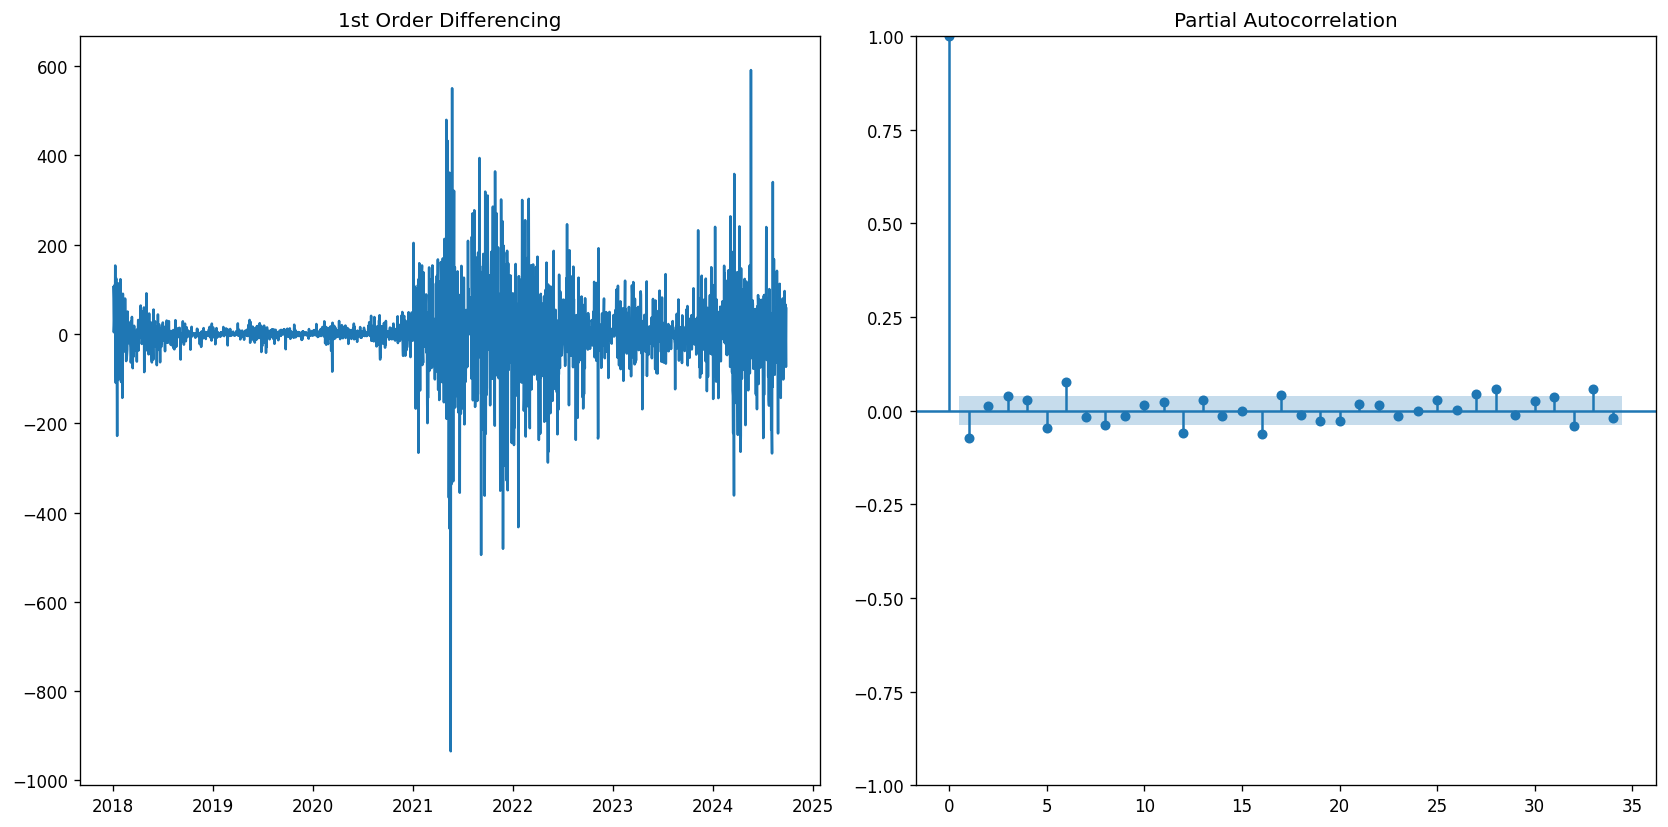

In [ ]:
fig2, axes2 = plt.subplots(1, 2, sharex=False)
axes2[0].plot(s1)
axes2[0].set_title('1st Order Differencing')
plot_pacf(s1, ax=axes2[1])
fig2.tight_layout()
fig2.show()

In [ ]:
model = ARIMA(data.Close, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2462
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -14251.341
Date:                Tue, 14 Oct 2025   AIC                          28506.683
Time:                        11:53:50   BIC                          28518.299
Sample:                             0   HQIC                         28510.903
                               - 2462                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0740      0.011     -6.785      0.000      -0.095      -0.053
sigma2      6270.2002     61.615    101.765      0.000    6149.438    6390.963
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [ ]:
pred = model_fit.predict(0, len(data)-1)
pred.head()

,predicted_mean
time,
2018-01-01,0.000000
2018-01-02,756.869011
2018-01-03,854.220200
2018-01-04,935.245664
2018-01-05,944.554041


In [ ]:
df_pred = pd.DataFrame(pred)
df_pred.rename(columns={'predicted_mean': 'Predicted'}, inplace=True)

df_pred.index = data.index[:len(df_pred)]

df_pred.head()

,Predicted
time,
2018-01-01,0.000000
2018-01-02,756.869011
2018-01-03,854.220200
2018-01-04,935.245664
2018-01-05,944.554041


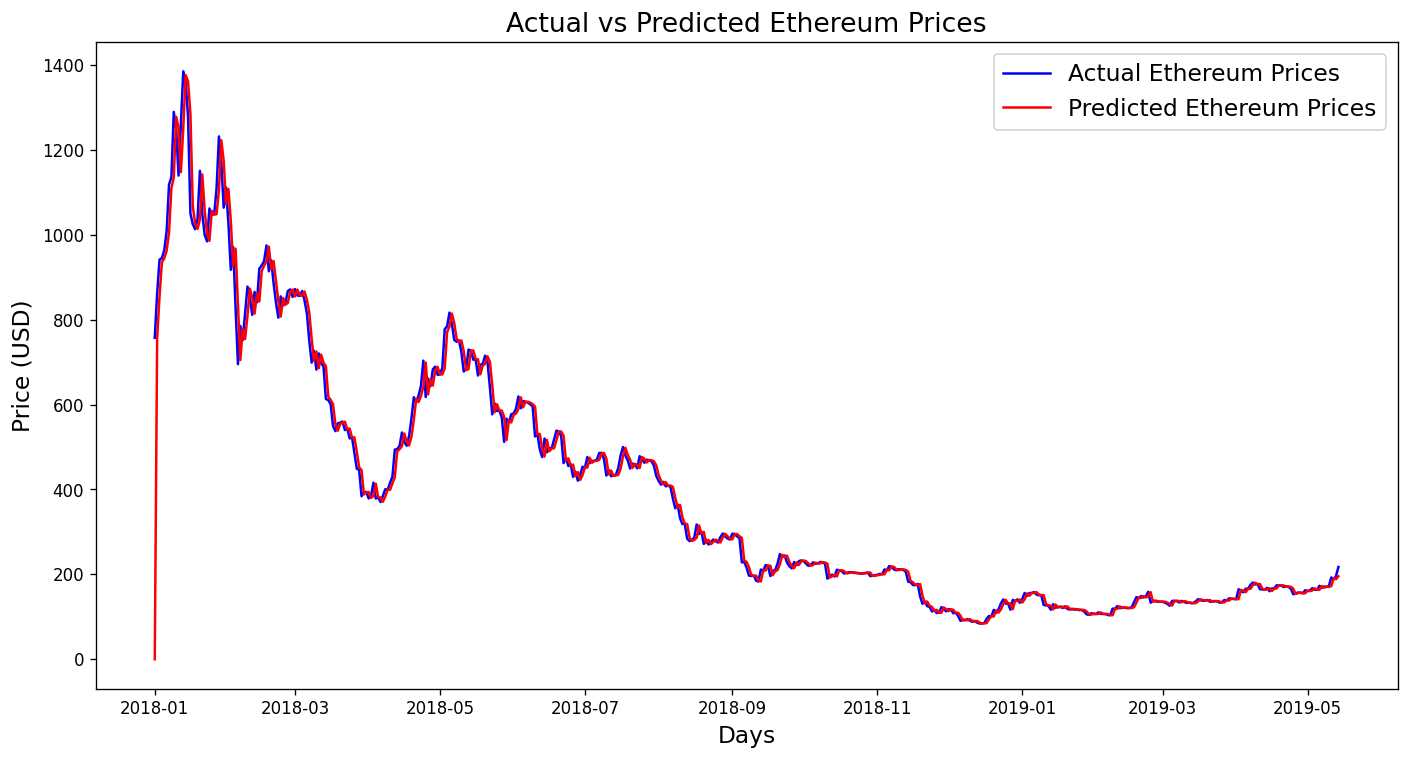

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data.Close[:500], label='Actual Ethereum Prices', color = 'blue')
plt.plot(df_pred['Predicted'][:500], color='red', label='Predicted Ethereum Prices')
plt.xlabel('Days', fontsize = 14)
plt.ylabel('Price (USD)', fontsize = 14)
plt.title('Actual vs Predicted Ethereum Prices', fontsize = 16)
plt.legend(fontsize = 14)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

true_values = data.Close[:len(pred)]

true_values.head()

,Close
time,
2018-01-01,757.22
2018-01-02,861.97
2018-01-03,941.10
2018-01-04,944.83
2018-01-05,963.88


In [ ]:
mae = mean_absolute_error(true_values, pred)

rmse = np.sqrt(mean_squared_error(true_values, pred))

mape = np.mean(np.abs((true_values - pred) / np.clip(true_values, 1e-10, None))) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 43.91
Root Mean Squared Error (RMSE): 80.64
Mean Absolute Percentage Error (MAPE): 3.23%


In [ ]:
data_shifted = data.Close.shift(1)
data_shifted.head()

,Close
time,
2018-01-01,NaN
2018-01-02,757.22
2018-01-03,861.97
2018-01-04,941.10
2018-01-05,944.83
